## Preprocessing

In [54]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,roc_curve,auc,f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import gensim
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, GRU, BatchNormalization, Conv1D, GlobalMaxPooling1D

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df = pd.read_csv('SpamVsHam.tsv', delimiter='\t', header=None, names=['Label', 'Message'])
print(df.head())
print("Shape : ", df.shape, "\n")
print(df.info())
print("\n Class distribution :", df['Label'].value_counts())


  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Shape :  (5572, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

 Class distribution : Label
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
## preprocess
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)

    stop = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop]

    text = ' '.join(tokens)
    return text

df['Message'] = df['Message'].apply(preprocess)

print("Cleaned text:", df.head())

Cleaned text:   Label                                            Message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry 2 wkly comp win fa cup final tkts 2...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


## Feature Extraction Techniques

In [6]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Message']).toarray()

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (5572, 5000)


In [7]:
#Word2Vec
TokenTexts = df['Message'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=TokenTexts, vector_size=100, window=5, min_count=1, workers=2)
#Try relatively default parameters for word2vec.

def vectorize(text, model):
    vector = np.zeros(model.vector_size)
    n_words = 0

    for word in word_tokenize(text):
        if word in model.wv:
            vector += model.wv[word]
            n_words += 1

    if n_words > 0:
        vector /= n_words 
    return vector

X_word2vec = np.array([vectorize(text, word2vec_model) for text in df['Message']])
print("Word2Vec shape:", X_word2vec.shape)

Word2Vec shape: (5572, 100)


## Modeling: Random Forest (TF-IDF)

In [57]:
X = X_tfidf  
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
print("Unique labels after conversion:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

unique_classes_train = np.unique(y_train)
unique_classes_test = np.unique(y_test)
print("Unique classes in y_train:", unique_classes_train)
print("Unique classes in y_test:", unique_classes_test) 

Unique labels after conversion: [0 1]
Unique classes in y_train: [0 1]
Unique classes in y_test: [0 1]


In [58]:
X_res, y_res = SMOTE(random_state=1).fit_resample(X_train, y_train)
X_res, y_res = TomekLinks().fit_resample(X_res, y_res)

rf_classifierTF = RandomForestClassifier(n_estimators=37, criterion = 'entropy', random_state=1)
#rf_classifierTF.fit(X_train, y_train)
rf_classifierTF.fit(X_res, y_res)

y_pred = rf_classifierTF.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC :", roc_auc_score(y_test, y_pred))
#estimator= 100 => 97.37%
#estimator= 37 => 97.37%

Accuracy: 0.9802631578947368

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.99      0.86      0.92       224

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672

ROC : 0.9282261247040252


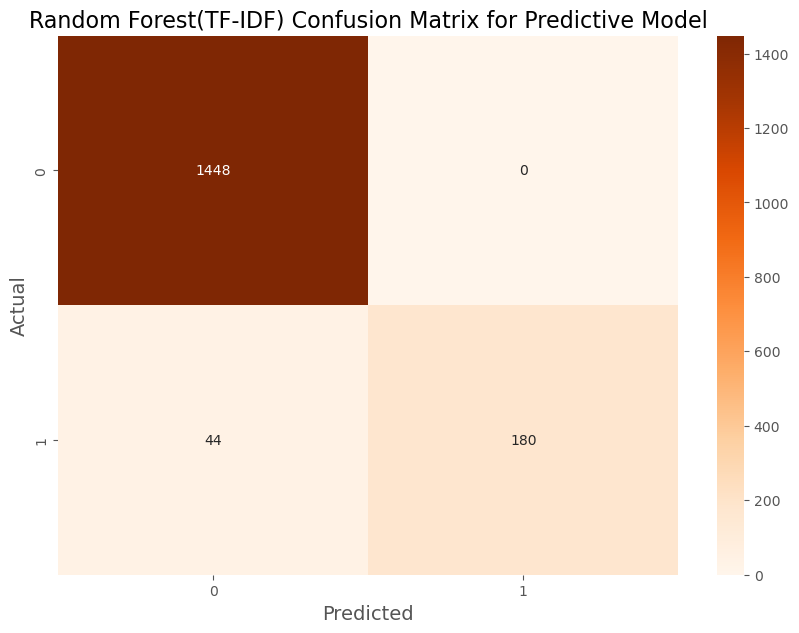

0.9736842105263158

In [8]:
cm = confusion_matrix(y_test, y_pred)


# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True,cmap='Oranges', fmt='g')
plt.title('Random Forest(TF-IDF) Confusion Matrix for Predictive Model', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()
accuracy_score(y_test, y_pred)

In [54]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

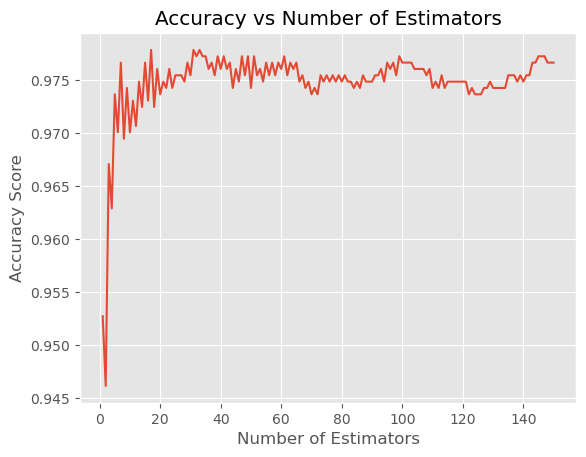

In [55]:
plt.plot(n_estimators_range, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.show()

In [9]:
parameter = {'n_estimators': range(5, 41)}
model = RandomForestClassifier(criterion='entropy', random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_estimator_.get_params()['n_estimators']
print(f"The best number of estimators is: {best_n_estimators}")
#The best number ofestimators is 37


KeyboardInterrupt: 

## Modeling: Random Forest (Word2Vec)

In [46]:
X = X_word2vec
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


X_res, y_res = SMOTE(random_state=1).fit_resample(X_train, y_train)

rf_classifierW2V = RandomForestClassifier(n_estimators=47, criterion = 'entropy', random_state=1) 
#rf_classifierW2V.fit(X_train, y_train)
rf_classifierW2V.fit(X_res, y_res)

y_pred = rf_classifierW2V.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC :", roc_auc_score(y_test, y_pred))
#estimators = 100 => 94.85%
#estimators = 47  => 95.16%

Accuracy: 0.9560538116591928

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       966
           1       0.89      0.77      0.82       149

    accuracy                           0.96      1115
   macro avg       0.93      0.88      0.90      1115
weighted avg       0.95      0.96      0.95      1115

ROC : 0.8753039587588757


In [ ]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

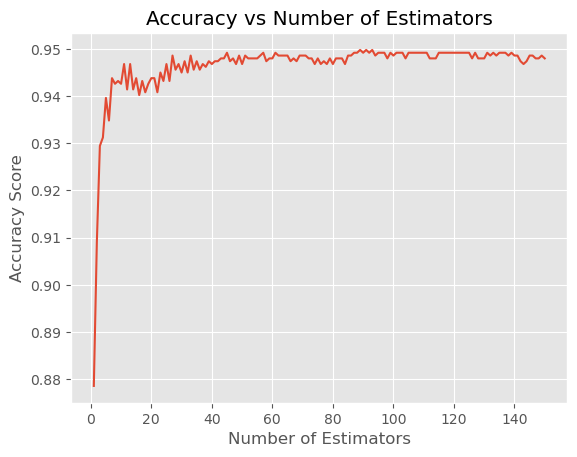

In [17]:
plt.plot(n_estimators_range, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.show()

In [18]:

parameter = {'n_estimators': range(20, 50)}
model = RandomForestClassifier(criterion='entropy', random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_estimator_.get_params()['n_estimators']
print(f"The best number of estimators is: {best_n_estimators}")
#The best number of estimators is: 47

The best number of estimators is: 47


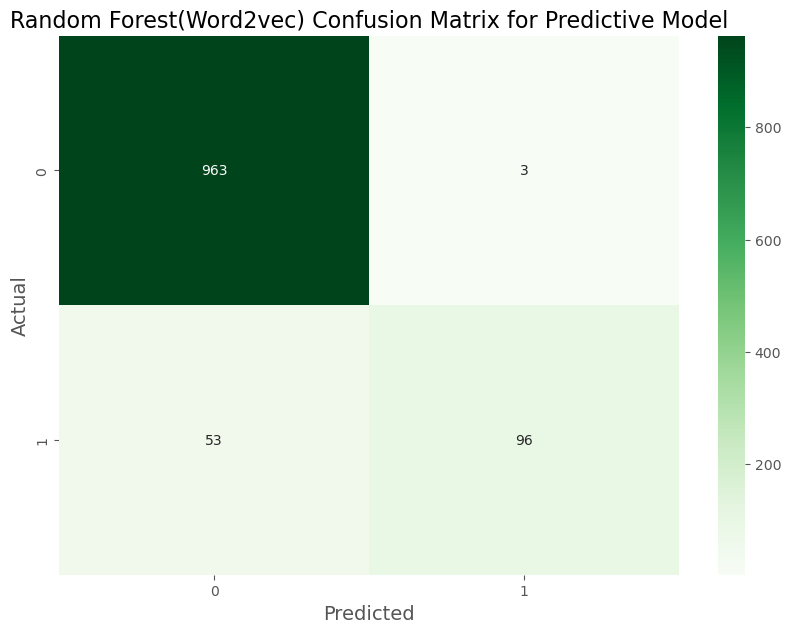

0.9497757847533632

In [13]:
cm = confusion_matrix(y_test, y_pred)


# Plotting


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True,cmap='Greens', fmt='g')
plt.title('Random Forest(Word2vec) Confusion Matrix for Predictive Model', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()
accuracy_score(y_test, y_pred)

## CNN

In [7]:

X_tfidf_reshaped = np.expand_dims(X_tfidf, axis=2) 

print("Reshaped TF-IDF shape:", X_tfidf_reshaped.shape)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

modelCNNTF = Sequential()
modelCNNTF.add(Conv1D(128, 5, activation='relu', input_shape=(X_tfidf_reshaped.shape[1], 1)))
modelCNNTF.add(BatchNormalization())
modelCNNTF.add(GlobalMaxPooling1D())
modelCNNTF.add(Dense(10, activation='relu'))
modelCNNTF.add(BatchNormalization())
modelCNNTF.add(Dense(1, activation='sigmoid'))

modelCNNTF.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X_tfidf_reshaped, y, test_size=0.3, random_state=1, stratify=y)
modelCNNTF.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

results = modelCNNTF.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


Reshaped TF-IDF shape: (5572, 5000, 1)


Epoch 1/10


61/61 [==============================] - 18s 271ms/step - loss: 0.6168 - accuracy: 0.7605 - val_loss: 0.7778 - val_accuracy: 0.1340
Epoch 2/10
61/61 [==============================] - 16s 258ms/step - loss: 0.4946 - accuracy: 0.8408 - val_loss: 0.6724 - val_accuracy: 0.6812
Epoch 3/10
61/61 [==============================] - 16s 257ms/step - loss: 0.4204 - accuracy: 0.8759 - val_loss: 0.4961 - val_accuracy: 0.8660
Epoch 4/10
61/61 [==============================] - 16s 267ms/step - loss: 0.3667 - accuracy: 0.8833 - val_loss: 0.4060 - val_accuracy: 0.8660
Epoch 5/10
61/61 [==============================] - 18s 297ms/step - loss: 0.3390 - accuracy: 0.8828 - val_loss: 0.3697 - val_accuracy: 0.8660
Epoch 6/10
61/61 [==============================] - 18s 291ms/step - loss: 0.3201 - accuracy: 0.8844 - val_loss: 0.3822 - val_accuracy: 0.8660
Epoch 7/10
61/61 [==============================] - 18s 302ms/step - loss: 0.3127 - accuracy: 0.884

53/53 [==============================] - 1s 24ms/step


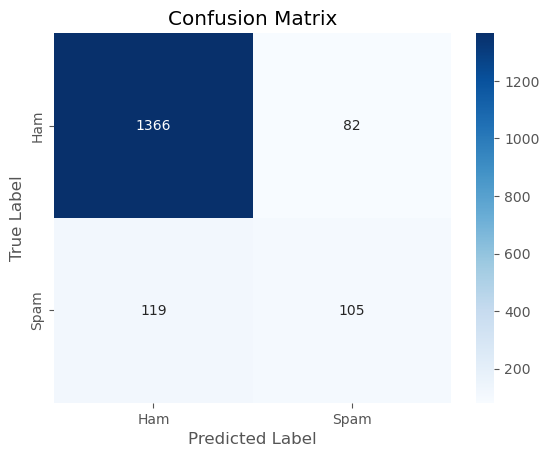

In [17]:
y_pred_prob = modelCNNTF.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [31]:
X_word2vec_reshaped = np.expand_dims(X_word2vec, axis=2)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

modelCNNW2V = Sequential()
modelCNNW2V.add(Conv1D(128, 5, activation='relu', input_shape=(X_word2vec_reshaped.shape[1], 1)))
modelCNNW2V.add(BatchNormalization())
modelCNNW2V.add(GlobalMaxPooling1D())
modelCNNW2V.add(Dropout(0.2))
modelCNNW2V.add(Dense(10, activation='relu'))
modelCNNW2V.add(Dense(1, activation='sigmoid'))

modelCNNW2V.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_reshaped, y, test_size=0.2, random_state=1, stratify=y)
modelCNNW2V.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# 评估模型
results = modelCNNW2V.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


Epoch 1/10
70/70 [==============================] - 2s 12ms/step - loss: 0.7189 - accuracy: 0.5421 - val_loss: 0.6814 - val_accuracy: 0.8664
Epoch 2/10
70/70 [==============================] - 0s 6ms/step - loss: 0.6772 - accuracy: 0.4552 - val_loss: 0.6624 - val_accuracy: 0.5740
Epoch 3/10
70/70 [==============================] - 0s 6ms/step - loss: 0.6688 - accuracy: 0.4932 - val_loss: 0.6687 - val_accuracy: 0.4493
Epoch 4/10
70/70 [==============================] - 0s 7ms/step - loss: 0.6693 - accuracy: 0.4398 - val_loss: 0.6541 - val_accuracy: 0.5139
Epoch 5/10
70/70 [==============================] - 0s 6ms/step - loss: 0.6600 - accuracy: 0.4463 - val_loss: 0.6551 - val_accuracy: 0.5552
Epoch 6/10
70/70 [==============================] - 0s 6ms/step - loss: 0.6522 - accuracy: 0.5080 - val_loss: 0.6874 - val_accuracy: 0.4323
Epoch 7/10
70/70 [==============================] - 0s 6ms/step - loss: 0.6632 - accuracy: 0.4413 - val_loss: 0.6584 - val_accuracy: 0.4996
Epoch 8/10
70/70 [=

35/35 [==============================] - 0s 2ms/step


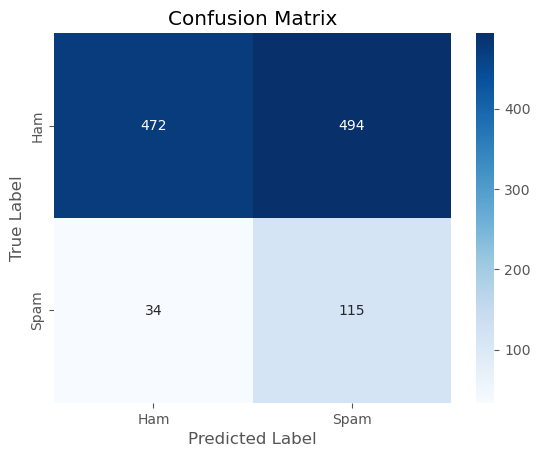

In [32]:
y_pred_prob = modelCNNW2V.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## SPAM Generation

In [11]:
spam_msg = df[df['Label'] == 'spam']['Message']
spam_msg = spam_msg.apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spam_msg)
sequences = tokenizer.texts_to_sequences(spam_msg)
seq_length = 10

train_sequences = []
for sequence in sequences:
    for i in range(seq_length, len(sequence)):
        train_sequences.append(sequence[i-seq_length:i+1])

train_sequences = pad_sequences(train_sequences, maxlen=seq_length+1, padding='pre')
train_sequences = np.array(train_sequences)
X, y = train_sequences[:, :-1], train_sequences[:, -1]
y = to_categorical(y, num_classes=len(tokenizer.word_index)+1)


In [13]:

Vsize = len(tokenizer.word_index) + 1

modelSPAM = Sequential()
modelSPAM.add(Embedding(Vsize, 50, input_length=seq_length))
modelSPAM.add(LSTM(150, return_sequences=True))
modelSPAM.add(LSTM(150))
modelSPAM.add(Dense(150, activation='relu'))
modelSPAM.add(Dense(Vsize, activation='softmax'))

modelSPAM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelSPAM.fit(X, y, batch_size=64, epochs=100)



Epoch 1/100


83/83 [==============================] - 4s 14ms/step - loss: 7.3667 - accuracy: 0.0243
Epoch 2/100
83/83 [==============================] - 1s 14ms/step - loss: 6.7232 - accuracy: 0.0330
Epoch 3/100
83/83 [==============================] - 1s 15ms/step - loss: 6.5736 - accuracy: 0.0330
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 6.4833 - accuracy: 0.0332
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 6.2677 - accuracy: 0.0338
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 6.0651 - accuracy: 0.0370
Epoch 7/100
83/83 [==============================] - 1s 15ms/step - loss: 5.8674 - accuracy: 0.0398
Epoch 8/100
83/83 [==============================] - 1s 14ms/step - loss: 5.6444 - accuracy: 0.0441
Epoch 9/100
83/83 [==============================] - 1s 14ms/step - loss: 5.3281 - accuracy: 0.0579
Epoch 10/100
83/83 [==============================] - 1s 17ms/step - loss: 4.9300 - accuracy: 0.

In [61]:
def generate_text(model, tokenizer, seq_length, seed_text, num_gen_words):
    output_text = []
    input_text = seed_text
    for _ in range(num_gen_words):
        encoded = tokenizer.texts_to_sequences([input_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        
        # 使用 model.predict 获取预测结果，并使用 np.argmax 找到最可能的类别索引
        predictions = model.predict(encoded, verbose=0)
        pred_word_index = np.argmax(predictions, axis=-1)[0]
        pred_word = tokenizer.index_word.get(pred_word_index, '')
        
        input_text += ' ' + pred_word
        output_text.append(pred_word)
    
    return ' '.join(output_text)

# 生成新的 SPAM-like 邮件
generated_texts = []
seed_texts = [
    "TOday IS JIMMY's BirTHday",
    "hihihihiiihi",
    "Fakerrrrrrr wat was datttt",
    "AM i jasoidfjiowjeo",
    "winner winner chicken dinner",
    "The competition is over",
    "Buy one get ten free",
    "How can I fix My broken heart",
    "CINDNDJFYYY NOOO",
    "OOH why you get me so high, to leave me so low, to leave me solo"
    ]
for seed in seed_texts:
    new_text = generate_text(modelSPAM, tokenizer, seq_length, seed, 10)  # 这里生成每条文本的长度为20个单词
    generated_texts.append(new_text)
while len(generated_texts) < 100:
    for seed in seed_texts:
        new_text = generate_text(modelSPAM, tokenizer, seq_length, seed, 10)
        generated_texts.append(new_text)
        if len(generated_texts) >= 100:
            break

print("Total generated texts:", len(generated_texts))
print(generated_texts[:10])  


Total generated texts: 100
['tcs c qlynnbv per msg 2 2 86688 08718738001 150p', '62220cncl 4 pix qlynnbv receive msg 2 enter cash draw', '62220cncl 4 pix qlynnbv receive msg 2 enter cash draw', 'get wwwtklscom subscribe subscribe offer offer callcost 18 u years', '62220cncl 4 pix qlynnbv receive msg 2 enter cash draw', 'tcs c qlynnbv per msg 2 2 86688 08718738001 150p', '62220cncl 4 pix qlynnbv receive msg 2 enter cash draw', '62220cncl 4 pix qlynnbv receive msg 2 enter cash draw', 'get wwwtklscom subscribe subscribe offer offer callcost 18 u years', '62220cncl 4 pix qlynnbv receive msg 2 enter cash draw']


## SPAM testing

In [15]:
## preprocess
def preprocess(new_text):
    new_text = new_text.lower()
    new_text = new_text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(new_text)

    stop = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop]

    new_text = ' '.join(tokens)
    return new_text

processed_texts = [preprocess(text) for text in generated_texts]

# 打印前5条预处理后的文本
print(processed_texts[:5])

['tcs c qlynnbv per msg 2 2 86688 08718738001 150p', 'receive qlynnbv receive msg receive enter cash draw xt music', '150p wap u c c qlynnbv 4 latest phones please', 'get wwwtklscom subscribe subscribe offer offer callcost 18 u years', '62220cncl 4 pix qlynnbv receive msg 2 enter cash draw']


In [28]:
def vectorize_text(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

processed_texts_word2vec = np.array([vectorize_text(text, word2vec_model) for text in processed_texts])
processed_texts_tfidf = tfidf_vectorizer.transform(processed_texts)

In [59]:
RF_pred_tfidf = rf_classifierTF.predict(processed_texts_tfidf)

true_labels = [1] * len(processed_texts)
print(classification_report(true_labels, RF_pred_tfidf))
print("Accuracy:", accuracy_score(true_labels, RF_pred_tfidf))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.20      0.33       100

    accuracy                           0.20       100
   macro avg       0.50      0.10      0.17       100
weighted avg       1.00      0.20      0.33       100

Accuracy: 0.2


In [48]:
true_labels = [1] * len(processed_texts)
RF_pred_word2vec = rf_classifierW2V.predict(processed_texts_word2vec)
print(classification_report(true_labels, RF_pred_word2vec))
print("Accuracy:", accuracy_score(true_labels, RF_pred_word2vec))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.20      0.33       100

    accuracy                           0.20       100
   macro avg       0.50      0.10      0.17       100
weighted avg       1.00      0.20      0.33       100

Accuracy: 0.2


In [28]:
processed_texts_tfidf_reshaped = np.expand_dims(processed_texts_tfidf.toarray(), axis=2)
predicted_labels = modelCNNTF.predict(processed_texts_tfidf_reshaped)
predicted_labels = (predicted_labels > 0.5).astype(int).flatten()
print(classification_report(true_labels, predicted_labels))
print("Accuracy:", accuracy_score(true_labels, predicted_labels))

4/4 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     100.0

    accuracy                           0.00     100.0
   macro avg       0.00      0.00      0.00     100.0
weighted avg       0.00      0.00      0.00     100.0

Accuracy: 0.0


In [33]:
processed_texts_word2vec_reshaped = np.expand_dims(processed_texts_word2vec, axis=2)
predicted_labels = modelCNNW2V.predict(processed_texts_word2vec_reshaped)
predicted_labels = (predicted_labels > 0.5).astype(int).flatten()
print(classification_report(true_labels, predicted_labels))
print("Accuracy:", accuracy_score(true_labels, predicted_labels))

4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     100.0

    accuracy                           0.00     100.0
   macro avg       0.00      0.00      0.00     100.0
weighted avg       0.00      0.00      0.00     100.0

Accuracy: 0.0
